In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import requests
from pyspark.sql import SparkSession
import numpy  as np
import pandas as pd
import csv
import re

In [3]:
#spark = SparkSession.builder.appName("HadoopTp").getOrCreate()

In [4]:
gcs_df  = pd.read_csv("./data/gcs-apr5.csv")

In [5]:
gcs_df.shape

(25000, 10)

In [6]:
expand_df = gcs_df['Geography'].str.split('-', expand=True)

In [7]:
expand_df[1].value_counts()

SOUTH        9439
MIDWEST      7005
WEST         4773
NORTHEAST    3781
Name: 1, dtype: int64

In [8]:
gcs_df['region'] = expand_df[1].values

In [9]:
gcs_df['etat'] = expand_df[2].values

In [10]:
#df["region"].value_counts(normalize=True)

## Nettoyage des données


Dans les données il y a plusieurs lignes qui contiennent "Unknown" comme valeur
Vu que les données sont des données catégoriques, je fais le choix de remplacer toutes les valeurs inconnues par la classe modale. 

In [11]:
gcs_df["Question #1 Answer"].value_counts()

None of the above / Not working for pay        10827
I continue to commute to work                   5323
Used to commute, now work from home             4834
Used to work from home and still do             2071
I have recently been furloughed or laid-off     1667
Used to work from home, but now I commute        278
Name: Question #1 Answer, dtype: int64

In [12]:
ddd = gcs_df[gcs_df["Question #1 Answer"] != "None of the above / Not working for pay"]

In [13]:
ddd.region.value_counts()

SOUTH        5235
MIDWEST      4132
WEST         2630
NORTHEAST    2174
Name: region, dtype: int64

In [14]:
gcs_df = gcs_df[gcs_df["Question #1 Answer"]!= "None of the above / Not working for pay"]

##### s = pd.Series(["M", "M", "Unknown", "F", "F", "M", "F", "F", "Unknown"])

In [15]:
gcs_df.head()

,User ID,Time (UTC),Survey Completion,Publisher Category,Gender,Age,Geography,Weight,Question #1 Answer,Response Time #1 (ms),region,etat
1,1000296325,2020-04-02 03:00:00,Complete,News,Male,55-64,US-SOUTH-AL-Muscle Shoals,0.868838,I continue to commute to work,22582,SOUTH,AL
3,1000492508,2020-04-02 15:00:00,Complete,News,Male,55-64,US-SOUTH-TN-Nashville,0.868838,I continue to commute to work,20659,SOUTH,TN
4,1000512424,2020-04-03 14:00:00,Complete,News,Female,45-54,US-SOUTH-TX,0.966719,Used to work from home and still do,32449,SOUTH,TX
8,1000887655,2020-04-05 05:00:00,Complete,News,Unknown,Unknown,US-MIDWEST-IL-Bloomington,0.000000,"Used to commute, now work from home",13310,MIDWEST,IL
9,1000977342,2020-04-01 18:00:00,Complete,News,Female,45-54,US-NORTHEAST-PA-Lock Haven,1.117327,I continue to commute to work,21037,NORTHEAST,PA


In [16]:
#cols_to_fix = ["Gender", "Age", "Geography"]

In [17]:
#def replaceUknown(df, cols):
#    for col in cols:
#        col_without_uk = df[df[col] != 'Unknown']
#        mode_ = col_without_uk[col].mode().values[0]
#        df[col].str.replace('Unknown', mode_)
#    return df

In [18]:
#{#gcs_df = replaceUknown(gcs_df, cols_to_fix)

## Répartition des réponses aux questions

In [19]:
def map_region(geo):
    if geo != 'Unknown':
        geo = geo.split('-')[1]
    
    return geo

In [20]:
gcs_df = gcs_df[gcs_df['Geography']!= "Unknown"]

In [21]:
gcs_df['Geography'] = gcs_df['Geography'].apply(map_region)

In [22]:
gcs_df['Geography'].value_counts()

SOUTH        5235
MIDWEST      4132
WEST         2630
NORTHEAST    2174
Name: Geography, dtype: int64

In [23]:
gcs_df.groupby(["Question #1 Answer", 'Geography']).count()

User ID  Time (UTC)  \
Question #1 Answer                          Geography                        
I continue to commute to work               MIDWEST       1602        1602   
                                            NORTHEAST      710         710   
                                            SOUTH         2142        2142   
                                            WEST           869         869   
I have recently been furloughed or laid-off MIDWEST        501         501   
                                            NORTHEAST      277         277   
                                            SOUTH          530         530   
                                            WEST           359         359   
Used to commute, now work from home         MIDWEST       1443        1443   
                                            NORTHEAST      850         850   
                                            SOUTH         1673        1673   
                                            WEST           866         866   
Used to work from home and still do         MIDWEST        520         520   
                                            NORTHEAST      294         294   
                                            SOUTH          782         782   
                                            WEST           475         475   
Used to work from home, but now I commute   MIDWEST         66          66   
                                            NORTHEAST       43          43   
                                            SOUTH          108         108   
                                            WEST            61          61   

                                                       Survey Completion  \
Question #1 Answer                          Geography                      
I continue to commute to work               MIDWEST                 1602   
                                            NORTHEAST                710   
                                            SOUTH                   2142   
                                            WEST                     869   
I have recently been furloughed or laid-off MIDWEST                  501   
                                            NORTHEAST                277   
                                            SOUTH                    530   
                                            WEST                     359   
Used to commute, now work from home         MIDWEST                 1443   
                                            NORTHEAST                850   
                                            SOUTH                   1673   
                                            WEST                     866   
Used to work from home and still do         MIDWEST                  520   
                                            NORTHEAST                294   
                                            SOUTH                    782   
                                            WEST                     475   
Used to work from home, but now I commute   MIDWEST                   66   
                                            NORTHEAST                 43   
                                            SOUTH                    108   
                                            WEST                      61   

                                                       Publisher Category  \
Question #1 Answer                          Geography                       
I continue to commute to work               MIDWEST                  1602   
                                            NORTHEAST                 710   
                                            SOUTH                    2142   
                                            WEST                      869   
I have recently been furloughed or laid-off MIDWEST                   501   
                                            NORTHEAST                 277   
                                            SOUTH

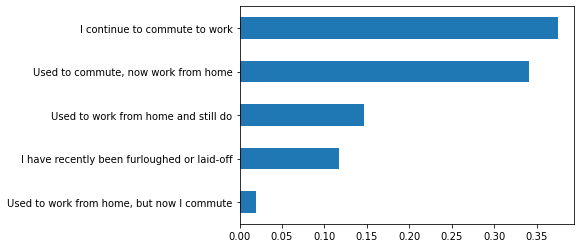

In [24]:
gcs_df['Question #1 Answer'].value_counts(normalize=True, ascending=True).plot.barh()

In [25]:
gcs_df['etat'].value_counts()

TX    743
IL    699
NC    690
VA    680
FL    629
OH    621
PA    620
MO    587
NY    582
CA    544
WI    527
GA    526
CO    518
MN    356
AL    348
MI    316
NJ    314
IN    313
IA    267
TN    263
AZ    259
WA    235
MA    232
UT    223
MS    222
OK    208
NE    205
SC    203
CT    203
OR    182
NM    180
MD    154
LA    152
NV    147
KY    139
ME    133
ID    128
KS     99
MT     90
ND     80
WV     77
DE     74
AR     71
HI     67
SD     62
DC     56
RI     40
AK     30
NH     28
WY     27
VT     22
Name: etat, dtype: int64

Aux USA prés de 2% ont répondu ne plus travaillé chez eux (Used to work from home, but now I commute),  15% faisait du télétravail et continue de le faire, prés de 34%  ont opté pour le télétravrail alors qu'ils se déplacaient au boulot. 37 % disent qu'ils continuent d'aller au boulot. 11% ont perdu leur boulot

In [26]:
#dd = pd.read_csv("https://raw.githubusercontent.com/johnjosephhorton/remote_work/master/etl/gcs-apr5.csv")

In [27]:
ddf = gcs_df[gcs_df["Question #1 Answer"] == "Used to commute, now work from home"]

In [28]:
mean_weight = ddf.groupby(['region']).mean()['Weight']


In [29]:
mean_weight

region
MIDWEST      0.632094
NORTHEAST    0.973722
SOUTH        0.829159
WEST         1.064526
Name: Weight, dtype: float64

In [30]:
ddf['region'].value_counts()

SOUTH        1673
MIDWEST      1443
WEST          866
NORTHEAST     850
Name: region, dtype: int64

In [31]:
import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(gcs_df['Weight'], gcs_df['Question #1 Answer'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
I continue to commute to work,I have recently been furloughed or laid-off,0.0054,0.9,-0.0302,0.0409,False
I continue to commute to work,"Used to commute, now work from home",0.0185,0.2613,-0.0066,0.0437,False
I continue to commute to work,Used to work from home and still do,-0.0339,0.0387,-0.0667,-0.0011,True
I continue to commute to work,"Used to work from home, but now I commute",-0.0474,0.4595,-0.1253,0.0304,False
I have recently been furloughed or laid-off,"Used to commute, now work from home",0.0132,0.839,-0.0228,0.0491,False
I have recently been furloughed or laid-off,Used to work from home and still do,-0.0393,0.076,-0.0809,0.0024,False
I have recently been furloughed or laid-off,"Used to work from home, but now I commute",-0.0528,0.4008,-0.1348,0.0292,False
"Used to commute, now work from home",Used to work from home and still do,-0.0524,0.001,-0.0857,-0.0192,True
"Used to commute, now work from home","Used to work from home, but now I commute",-0.0659,0.1432,-0.144,0.0121,False
Used to work from home and still do,"Used to work from home, but now I commute",-0.0135,0.9,-0.0944,0.0673,False


### Analyse des données par région

In [32]:
#from plotnine import *

In [33]:
!pip install 'plotnine[all]'

In [34]:
def repartitionPerResponse(dafarame):
    

    df = dafarame.copy()
    df["Question #1 Answer"] = df["Question #1 Answer"].astype(str)
    
    continue_commit_work_df = df[df["Question #1 Answer"] == "I continue to commute to work"]
    recently_laid_off_df =  df[df["Question #1 Answer"] == "I have recently been furloughed or laid-off"]
    use_to_commute_work_home_df = df[df["Question #1 Answer"] == "Used to commute, now work from home"]
    use_to_work_home_still_do_df = df[df["Question #1 Answer"] == "Used to work from home and still do"]
    
    f, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
    #axis = axes.flatten()
    
    continue_commit_work_df['region'].value_counts(normalize=True, ascending=False).plot.bar(ax=axes[0, 0])
    axes[0, 0].set_title("I continue to\n commute to work", y=1.05, fontsize=12)

    
    recently_laid_off_df['region'].value_counts(normalize=True, ascending=False).plot.bar(ax=axes[0, 1])
    axes[0, 1].set_title("I have recently been\n furloughed or laid−off", y=1.05, fontsize=12)

    use_to_commute_work_home_df['region'].value_counts(normalize=True, ascending=False).plot.bar(ax=axes[1, 0])
    axes[1, 0].set_title("Used to commute,\nnow work from home", fontsize=12)
    
    use_to_work_home_still_do_df['region'].value_counts(normalize=True, ascending=False).plot.bar(ax=axes[1, 1])
    axes[1, 1].set_title("Used to work from home \nand still do", fontsize=12)
    
    f.autofmt_xdate(rotation=45)
    plt.show()
    
    
    

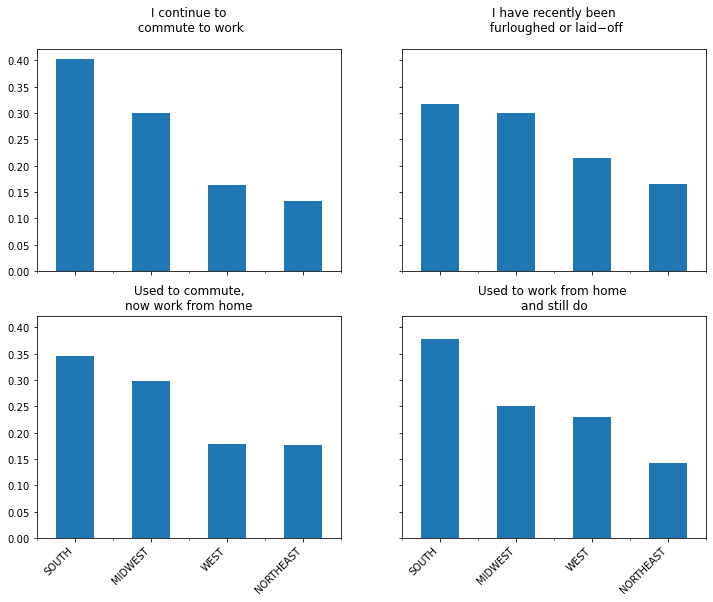

In [35]:
repartitionPerResponse(gcs_df)

In [36]:
def repartitionByRegion(dafarame):
    

    df = dafarame.copy()
    df["Question #1 Answer"] = df["Question #1 Answer"].astype(str)
    
    south_df = df[df["region"] == "SOUTH"]
    west_df =  df[df["region"] == "WEST"]
    midwest_df = df[df["region"] == "MIDWEST"]
    northeast_df = df[df["region"] == "NORTHEAST"]
    
    f, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
    #axis = axes.flatten()
    
    northeast_df["Question #1 Answer"].value_counts(normalize=True, ascending=False).plot.barh(ax=axes[0, 0])
    axes[0, 0].set_title("NORTHEAST", y=1.05, fontsize=12)

    
    midwest_df["Question #1 Answer"].value_counts(normalize=True, ascending=False).plot.barh(ax=axes[0, 1])
    axes[0, 1].set_title("MIDWEST", y=1.05, fontsize=12)

    west_df["Question #1 Answer"].value_counts(normalize=True, ascending=False).plot.barh(ax=axes[1, 0])
    axes[1, 0].set_title("WEST", fontsize=12)
    
    south_df["Question #1 Answer"].value_counts(normalize=True, ascending=False).plot.barh(ax=axes[1, 1])
    axes[1, 1].set_title("SOUTH", fontsize=12)
    
    f.autofmt_xdate(rotation=45)
    plt.show()
    

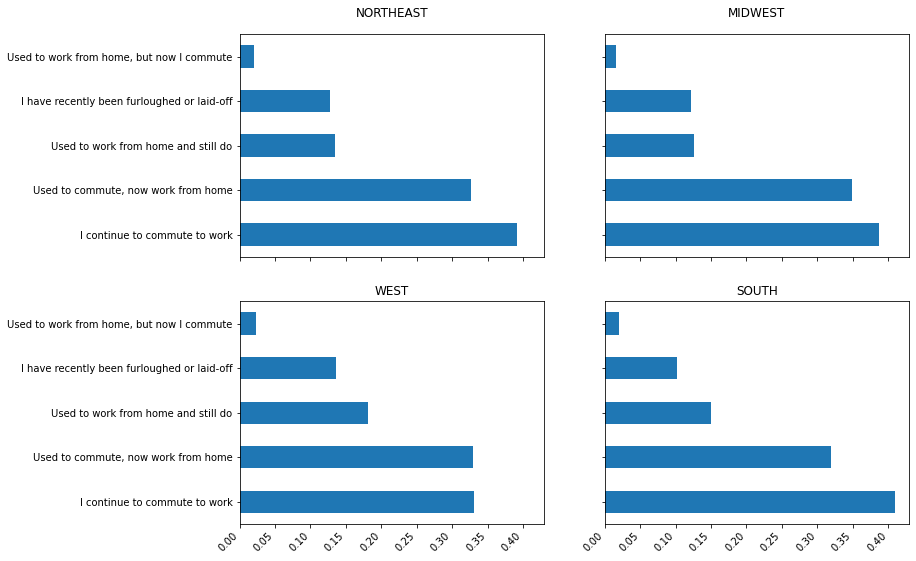

In [37]:
repartitionByRegion(gcs_df)

## Repartition par sexe

In [38]:
ccw_df = gcs_df[gcs_df["Question #1 Answer"] == "I continue to commute to work"]

In [39]:
ccw_df = ccw_df[ccw_df["Gender"]!='Unknown']

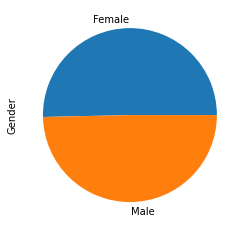

In [40]:
ccw_df["Gender"].value_counts().plot.pie()

In [41]:
def repartitionPerResponse(dafarame):
    

    df = dafarame.copy()
    df["Question #1 Answer"] = df["Question #1 Answer"].astype(str)
    
    continue_commit_work_df = df[df["Question #1 Answer"] == "I continue to commute to work"]
    recently_laid_off_df =  df[df["Question #1 Answer"] == "I have recently been furloughed or laid-off"]
    use_to_commute_work_home_df = df[df["Question #1 Answer"] == "Used to commute, now work from home"]
    use_to_work_home_still_do_df = df[df["Question #1 Answer"] == "Used to work from home and still do"]
    
    f, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
    #axis = axes.flatten()
    continue_commit_work_df = continue_commit_work_df[continue_commit_work_df.Gender != "Unknown"]
    continue_commit_work_df['Gender'].value_counts(normalize=True, ascending=False).plot.pie(ax=axes[0, 0])
    axes[0, 0].set_title("I continue to\n commute to work", y=1.05, fontsize=12)
   
    recently_laid_off_df = recently_laid_off_df[recently_laid_off_df.Gender != 'Unknown']
    recently_laid_off_df['Gender'].value_counts(normalize=True, ascending=False).plot.pie(ax=axes[0, 1])
    axes[0, 1].set_title("I have recently been\n furloughed or laid−off", y=1.05, fontsize=12)
    
    use_to_commute_work_home_df = use_to_commute_work_home_df[use_to_commute_work_home_df.Gender!="Unknown"]
    use_to_commute_work_home_df['Gender'].value_counts(normalize=True, ascending=False).plot.pie(ax=axes[1, 0])
    axes[1, 0].set_title("Used to commute,\nnow work from home", fontsize=12)
    
    use_to_work_home_still_do_df = use_to_work_home_still_do_df[use_to_work_home_still_do_df.Gender != "Unknown"]
    use_to_work_home_still_do_df['Gender'].value_counts(normalize=True, ascending=False).plot.pie(ax=axes[1, 1])
    axes[1, 1].set_title("Used to work from home \nand still do", fontsize=12)
    
    f.autofmt_xdate(rotation=45)
    plt.show()
    
    
    

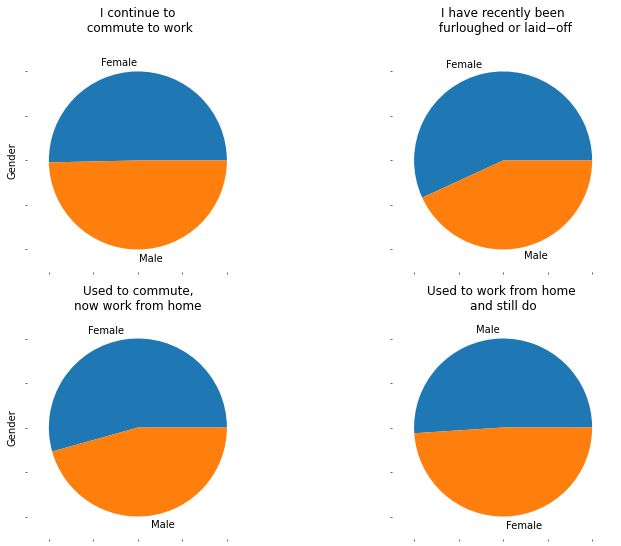

In [42]:
repartitionPerResponse(gcs_df)

In [43]:
def repartitionPerAge(dafarame):
    

    df = dafarame.copy()
    df["Question #1 Answer"] = df["Question #1 Answer"].astype(str)
    
    continue_commit_work_df = df[df["Question #1 Answer"] == "I continue to commute to work"]
    recently_laid_off_df =  df[df["Question #1 Answer"] == "I have recently been furloughed or laid-off"]
    use_to_commute_work_home_df = df[df["Question #1 Answer"] == "Used to commute, now work from home"]
    use_to_work_home_still_do_df = df[df["Question #1 Answer"] == "Used to work from home and still do"]
    
    f, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
    #axis = axes.flatten()
    continue_commit_work_df = continue_commit_work_df[continue_commit_work_df.Age!= "Unknown"]
    continue_commit_work_df['Age'].value_counts(normalize=True, ascending=False).plot.bar(ax=axes[0, 0])
    #sns.pointplot(x="Age", y="Weight", join=True, data=continue_commit_work_df, ax=axes[0, 0])
    axes[0, 0].set_title("I continue to\n commute to work", y=1.05, fontsize=12)
   
    recently_laid_off_df = recently_laid_off_df[recently_laid_off_df.Age != 'Unknown']
    recently_laid_off_df['Age'].value_counts(normalize=True, ascending=False).plot.bar(ax=axes[0, 1])
    axes[0, 1].set_title("I have recently been\n furloughed or laid−off", y=1.05, fontsize=12)
    
    use_to_commute_work_home_df = use_to_commute_work_home_df[use_to_commute_work_home_df.Age!="Unknown"]
    use_to_commute_work_home_df['Age'].value_counts(normalize=True, ascending=False).plot.bar(ax=axes[1, 0])
    axes[1, 0].set_title("Used to commute,\nnow work from home", fontsize=12)
    
    use_to_work_home_still_do_df = use_to_work_home_still_do_df[use_to_work_home_still_do_df.Age != "Unknown"]
    use_to_work_home_still_do_df['Age'].value_counts(normalize=True, ascending=False).plot.bar(ax=axes[1, 1])
    axes[1, 1].set_title("Used to work from home \nand still do", fontsize=12)
    
    f.autofmt_xdate(rotation=45)
    plt.show()
    
    
    

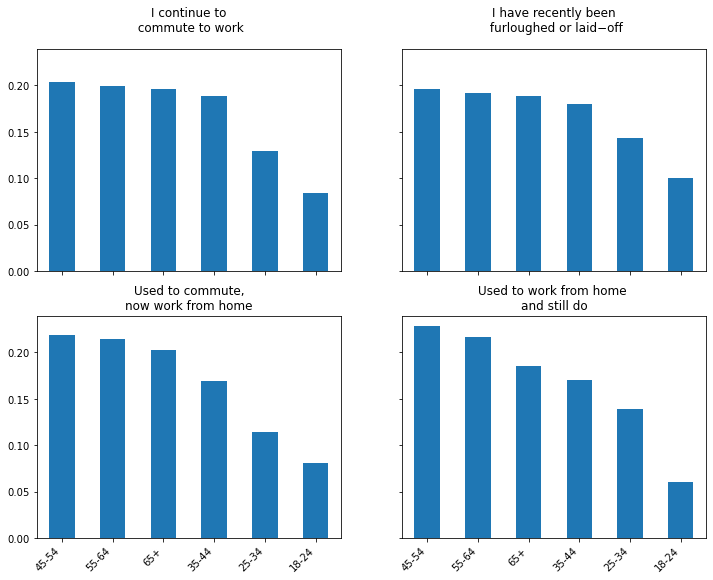

In [44]:
repartitionPerAge(gcs_df)

In [45]:
#gcs_df.head()

In [46]:
spark = SparkSession.builder.appName("filRouge").getOrCreate()

In [47]:
spark_df = spark.createDataFrame(gcs_df)

In [48]:
spark_df.write.option("header", "true").option("delimiter", ",").csv("hdfs://172.17.0.3:8020/user/cloudera/filRouge/remote_usa.csv")